<a href="https://colab.research.google.com/github/rajeev-shivaram/PyTorch101/blob/master/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CIFAR10 PyTorch

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import requests
from PIL import Image
from PIL import ImageOps

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [34]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform = transforms.Compose([transforms.Resize((32, 32)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                       ])

training_dataset = datasets.CIFAR10(root='./data', download=True, train=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', download=True, train=False, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def im_convert(tensor):
  """Returns the image from Tensor"""
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image / 2 + 0.5
  image = image.clip(0, 1)
  return image

In [0]:
classes = ['planes', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

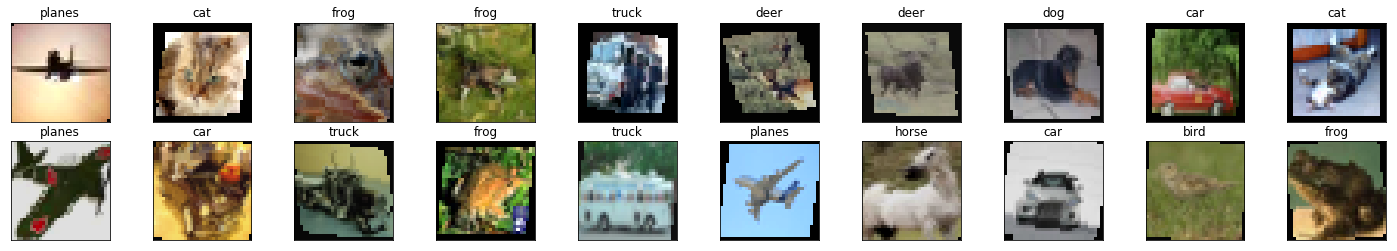

In [37]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [0]:
class LeNet(nn.Module):
  
  def __init__(self):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1)
    self.fc1 = nn.Linear(5*5*64, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 5*5*64)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [39]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1600, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [41]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in tqdm(range(epochs), ncols=200):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    
  else:
    
    with torch.no_grad():
      
      for val_inputs, val_labels in validation_loader:
        
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
    
    epoch_loss = running_loss / len(training_loader)
    epoch_acc = running_corrects.float() / len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_loss)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

ValueError: ignored

In [0]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

In [0]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [0]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/eb/British_Airways_Concorde_G-BOAC_03.jpg/220px-British_Airways_Concorde_G-BOAC_03.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

In [0]:
img = transform(img) 
plt.imshow(im_convert(img))

In [0]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

In [0]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))